# 0.0. Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

## 0.1 Helper Functions

In [2]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.filterwarnings("ignore")

def change_date(data, column):
    data[column] = pd.to_datetime(data[column], format='%Y-%m-%d')
    return data[column]


    
def descrever(df):
    num_attributes = df.select_dtypes(['int64', 'float64'])

    mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    median = pd.DataFrame(num_attributes.apply(np.median)).T

    min_ = pd.DataFrame(num_attributes.apply(np.min)).T
    max_ = pd.DataFrame(num_attributes.apply(np.max)).T
    std = pd.DataFrame(num_attributes.apply(np.std)).T
    range_ =  pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    kurtosis  = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    unique  = pd.DataFrame(num_attributes.apply(lambda x: x.nunique())).T


    metricas = pd.concat([ min_, max_, range_, mean, median, std, skew, kurtosis, unique]).T
    metricas.columns = [ 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis', 'unique']
    return metricas
    

## 0.3. Load Data 

In [3]:
df_geral = pd.read_csv('../data/new_dfs/df_geral.csv')
df_contrato =  pd.read_csv('../data/new_dfs/df_contrato.csv')
df_mensagem = pd.read_csv('../data/new_dfs/df_mensagem.csv')


# 1.0. Preparação dos Dados

## 1.1. Mudar tipo de data


In [4]:
#df_contrato
dates = ['dt_contrato', 'dt_desembolso','dt_vencimento', 'dt_wo' ]
for date in dates:
    df_contrato[date] = change_date(df_contrato, date)
    

#df_mensagem
df_mensagem['data_acao'] = change_date(df_mensagem, 'data_acao')
df_mensagem['dt_ref_portfolio'] = change_date(df_mensagem, 'dt_ref_portfolio')

#df_geral
df_geral['dt_ref_portfolio'] = change_date(df_geral, 'dt_ref_portfolio')


# 2.0. EDA

## 2.1. Cenário do programa no tempo

In [5]:
print('Total de contratos: {}'.format(len(df_contrato)))

print('\nValor pago esperado : R${:,.2f}'.format(df_contrato['debito_sem_pagamento'].sum()))

print('\nValor total pago: R${:,.2f}'.format(df_contrato['vlr_pgto_realizado'].sum()))

print('\nValor total inadimplente: R${:,.2f}'.format(  df_contrato['debito_sem_pagamento'].sum() - df_contrato['vlr_pgto_realizado'].sum()))   

print('\nSaldo até agora com o programa: R${:,.2f}'.format(df_contrato['valor_total_pago'].sum() -df_contrato['vlr_desembolsado'].sum())  )


Total de contratos: 14756

Valor pago esperado : R$581,875,001.09

Valor total pago: R$500,424,915.64

Valor total inadimplente: R$81,450,085.45

Saldo até agora com o programa: R$-11,707,166.48


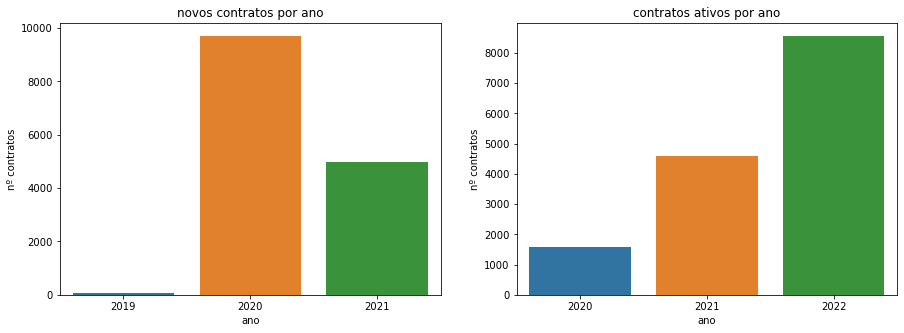

In [6]:
plt.figure(figsize=(15,5))


#df auxiliar
aux = df_contrato[['contrato_id','dt_contrato']].copy()

#extraindo  ano que o cliente efetou o contrato
aux['ano'] = aux['dt_contrato'].dt.year

#contando novos contratos por ano
aux = aux[['contrato_id','ano']].groupby('ano').count().reset_index()

#contratos por ano
plt.subplot(1,2,1)
sns.barplot(data=aux, x='ano', y='contrato_id').set_title('novos contratos por ano')
plt.ylabel('nº contratos');


#pegando ultimo registro de cada contrato
aux = df_geral[['contrato_id','dt_ref_portfolio']].groupby('contrato_id').max().reset_index()

#extraindo mes e ano
aux['ano'] = aux['dt_ref_portfolio'].dt.year

#contando contratos vigentes por ano
aux0 = aux[['contrato_id', 'ano']].groupby('ano').count().reset_index()

#contratos por ano
plt.subplot(1,2,2)

sns.barplot(data=aux0, x='ano', y='contrato_id').set_title('contratos ativos por ano')
plt.ylabel('nº contratos');

**Conclusão:** A maior parte dos contratos foram assinados em 2020 e 2021, e 

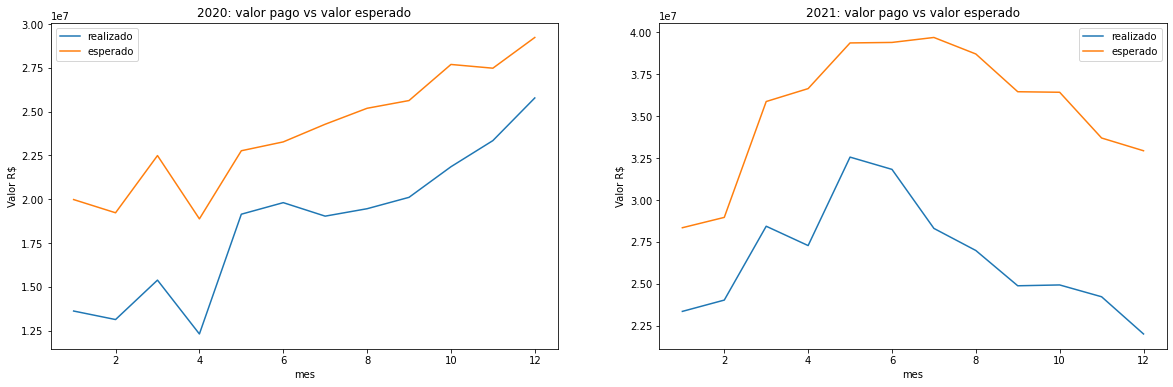

In [7]:
aux = df_geral[['vlr_pgto_realizado', 'dt_ref_portfolio', 'vlr_pgto_esperado']].copy()

#pegando mes e ano
aux['ano'] = df_geral['dt_ref_portfolio'].dt.year.astype('int64')
aux['mes'] = df_geral['dt_ref_portfolio'].dt.month.astype('int64')

#somando valor esperado e pago
aux0 = aux[['vlr_pgto_realizado', 'ano', 'mes']].groupby(['ano', 'mes']).sum().reset_index()
aux1 = aux[['vlr_pgto_esperado', 'ano', 'mes']].groupby(['ano', 'mes']).sum().reset_index()



plt.figure(figsize=(20,6))

# 2020 esperado vs realizado
plt.subplot(1,2,1)
sns.lineplot(data = aux0.loc[aux['ano']==2020], x='mes', y='vlr_pgto_realizado', ci=None)
sns.lineplot(data = aux1.loc[aux['ano']==2020], x='mes', y='vlr_pgto_esperado', ci=None).set_title('2020: valor pago vs valor esperado')
plt.ylabel('Valor R$')
plt.legend(['realizado', 'esperado'])


# 2021 esperado vs realizado
plt.subplot(1,2,2)
sns.lineplot(data = aux0.loc[aux0['ano']==2021], x='mes', y='vlr_pgto_realizado', ci=None)
sns.lineplot(data = aux1.loc[aux1['ano']==2021], x='mes', y='vlr_pgto_esperado', ci=None).set_title('2021: valor pago vs valor esperado')
plt.ylabel('Valor R$')
plt.legend(['realizado', 'esperado']);




## Atraso no pagamento

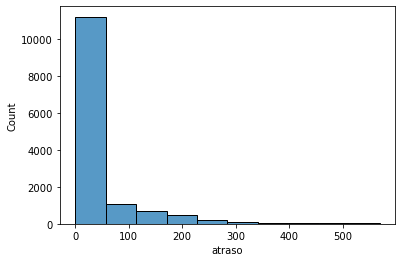

In [8]:
#pegando ultimo registro de cada contrato
aux = df_geral[['contrato_id','dt_ref_portfolio']].groupby('contrato_id').max().reset_index()

df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how = 'inner').rename(columns={'dt_ref_portfolio':'dt_ultimo_registro'})

df_contrato['atraso'] = (df_contrato['dt_ultimo_registro'] - df_contrato['dt_vencimento']).dt.days

df_contrato['atraso'] = df_contrato['atraso'].apply(lambda x: 0 if x<=0 else x)

aux = df_contrato[ df_contrato['status_contrato']!='Suspended']
sns.histplot(aux['atraso'], bins=10);

In [9]:
tx_atraso = len(aux[aux['atraso']>0])/len(df_contrato)*100
print('{:.2f}% dos contratos estão atrasados'.format(tx_atraso))

27.85% dos contratos estão atrasados


### Análise das eficiências

In [10]:
df_mensagem = df_mensagem[~df_mensagem['status'].isna()].reset_index(drop=True)
aux = df_mensagem[['status', 'contrato_id']].groupby('status').count().reset_index()

# normalizar
aux = pd.concat([aux, pd.DataFrame(data = {'status': 'TOTAL', 'contrato_id': len(df_mensagem)}, index=[0])])
aux['contrato_id'] = aux['contrato_id']/len(df_mensagem)*100
aux = aux.rename(columns={'contrato_id': '% mensagens'})

In [11]:
plt.figure(figsize=(10,10));
px.bar(aux.sort_values('% mensagens', ascending=True), x='% mensagens', y='status')


NameError: name 'px' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
print(f'Foram enviados {len(df_mensagem)} comunicados')

print('Destes, apenas {} foram lidos'.format(sum(df_mensagem['status'].isin(['LIDO', 'RESPONDIDO']))))
#quantas vezes o pagamento principal foi retornado, depois de um comunicado lido/respondido?

print('\nO pagamento  foi retomado, depois de um comunicado lido/respondido {} vezes.'.format(len(df_mensagem[df_mensagem['eficiencia']==1])))

print('\nO pagamento principal  foi retomado, depois de um comunicado lido/respondido {} vezes.'.format(len(df_mensagem[df_mensagem['eficiencia']==2])))

taxa = sum(df_mensagem['status'].isin(['LIDO', 'RESPONDIDO'])) /sum(df_mensagem['status'].isin(['ENTREGUE', 'LIDO', 'RESPONDIDO'])) 
print('\nTaxa de leitura: {:.2f}%'.format(100*taxa   ))

print('\nTaxa de eficiencia: {:.2f}% \n (pagamento retomado/total lido)'.format(len(df_mensagem[df_mensagem['eficiencia'].isin([1,2])])/len(df_mensagem[df_mensagem['status']=='LIDO'])*100))



### Dias de contrato vs eficiência de ações

In [ ]:

#eficiencia média das ações por contrato
aux = df_mensagem[['contrato_id', 'eficiencia']].groupby('contrato_id').mean().reset_index()
df_contrato = pd.merge(df_contrato, aux, on='contrato_id', how='left')

In [ ]:
#configurando dashboard
plt.figure(figsize=(10,12))
plt.tight_layout()

plt.subplot(2,1,1)

#agrupando prazo em anos
aux = df_contrato[['prazo', 'eficiencia']].copy()
aux['prazo_ano'] = df_contrato['prazo'].apply(lambda x: '<1 ano' if x<12 else '> 2 anos' if x>24 else 'entre 1 e 2 anos')

#grafico de barras
sns.barplot(data=aux.sort_values('prazo',ascending=True), x='eficiencia', y='prazo_ano').set_title('eficiência média por prazo do contrato');
plt.ylabel('prazo em anos')


plt.subplot(2,1,2)

#agrupando prazo em anos
aux = df_contrato[['dias_de_contrato', 'eficiencia']].copy()
aux['tempo_contrato_ano'] = df_contrato['dias_de_contrato'].apply(lambda x: '<1 ano' if x<365 else '> 2 anos' if x>730 else 'entre 1 e 2 anos')

#grafico de barras
sns.barplot(data=aux.sort_values('dias_de_contrato',ascending=True), x='eficiencia', y='tempo_contrato_ano').set_title('eficiência média por tempo de contrato');
plt.ylabel('tempo decorrido do contrato');


**Conclusão:** Quanto mais se extende o contrato, menos eficiência tem as ações. Ou seja, o quanto antes quitar o contrato menor o risco da inadimplência. A correlação é parecida em relação ao prazo, mas em menor grau.

**Sugestão**: Priorizar a comunicação nos primeiros dias de contrato, pois é quando o cliente está engajado. Se o contrato se extender muito, ficar de olho para não perder deixá-lo ficar inadimplente. Talvez mudando a estratégia da comunicação, para ser mais efetivo.

### Eficiência das campanhas

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
# plt.figure(figsize=(7,8))

#eficiencia por acão, filtrando somente linhas que tinham ações lidas ou respondidas
sns.barplot(data=df_lido[df_lido['status'].isin(['LIDO', 'RESPONDIDO'])], y='acao', x='eficiencia', estimator=np.mean).set_title('eficiencia das ações');

plt.subplot(1,2,2)

# plt.figure(figsize=(5,5))

sns.barplot(data=df_lido, x='tipo_acao', y='eficiencia', estimator=np.mean).set_title('eficiencia das ações pelo tipo');

Ranking e possível explicação:


1. Campanha de observação: Uma chamada após 5 dias sem pagamento. É a mais eficiente, em grande parte provavelmente por ser a primeira ação tendo poucos dias de inadimplência. Mais da metade volta a pagar depois desse tipo de comunicado.
2. Campanha Parcelamento: Uma chamada após 10 dias sem pagamento. Tem metade da eficiência da primeira, mas não deixa de ser eficiente. 
3. Campanha Pre Negativacao: Uma chamada após um mês sem pagamento. Provavelmente é eficiente por ser uma chamada mais dura e ainda não muito tarde de surtir efeito.
4. Campanha Boleto Quitado: Chamado após 15 dias e também 90. Uma promoção para quitar o boleto, provavelmente com uma promoção. Essa campanha deve ser melhorada, pois deveria ter um efeito melhor, devido ao curto tempo de acionamento em relação a campanha de pre-negativação.
5. Campanha Negativação: Uma chamada após 60 dias. Negativa efetivamente o nome da pessoa.

Não há diferença na eficiência por tipo de ação. 



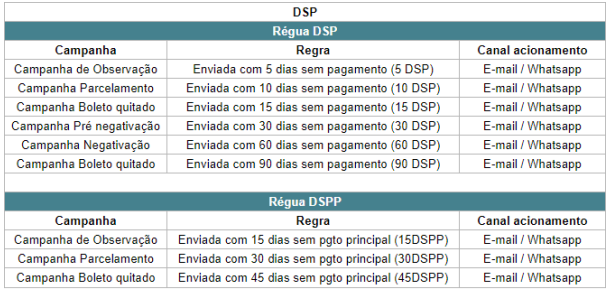

### Análise inadimplência 

In [ ]:
inadimplentes = df_contrato[df_contrato['status_contrato']=='Suspended']

#staatus do contrato Suspenso ou Ativo
aux = df_contrato[df_contrato['status_contrato'].isin(['Active', 'Suspended'])]

#Debito ativo
aux = aux[aux['debito']>0]

#Atraso na finalizacao do contrato
aux = aux[aux['atraso']>0]

#Data de write of inferior a data de hoje 
aux = aux[aux['dt_wo']<pd.to_datetime('04-05-2022')]

#ordenar pelos que tem maior atraso e maior debito
inadimplentes = aux.sort_values( ['atraso', 'debito'], ascending=[False, False]).reset_index(drop=True)

#### Segmento e subsegmento


In [ ]:
#configurando dashboard
plt.figure(figsize=(8,15))

plt.subplot(2,1,1)
aux = inadimplentes[['segmento', 'contrato_id']].groupby('segmento').count().sort_values('contrato_id', ascending=False).reset_index()
sns.barplot(data=aux,x='contrato_id',y='segmento').set_title('inadimplentes por segmento');
plt.xlabel('nº de contratos');


plt.subplot(2,1,2)
aux = inadimplentes[['subsegmento', 'contrato_id']].groupby('subsegmento').count().sort_values('contrato_id', ascending=False).reset_index().head()
sns.barplot(data=aux,x='contrato_id',y='subsegmento').set_title('inadimplentes por subsegmento');
plt.xlabel('nº de contratos');


## Por Localização

In [ ]:
plt.figure(figsize=(17,5))

plt.subplot(1,2,1)
aux = inadimplentes[['estado', 'contrato_id']].groupby('estado').count().sort_values('contrato_id', ascending=False).reset_index().head()
sns.barplot(data=aux,x='estado',y='contrato_id');
plt.title('inadimplentes por estado')
plt.xlabel(None)

plt.subplot(1,2,2)

aux = inadimplentes[['cidade', 'contrato_id']].groupby('cidade').count().sort_values('contrato_id', ascending=False).reset_index().head()
sns.barplot(data=aux,x='contrato_id',y='cidade')
plt.title('inadimplentes por cidade')
plt.ylabel(None);

**Conclusão:** Aqui dá para ter uma noção maior onde estão concentrados os inadimplentes. Eles estão obviamente nas grandes capitais e grandes centros. Seria necessário analisar a fundo para realizar ações específicas.

# 4.0. Resumo das principais conclusões